In [3]:
#Haven't used it
# !gdown --folder --id 1B19RWODijlUlXEdvLKxjcmlg-BiJcbWE -O /content/shared_folder

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 1tytlWWD1IqtyH3UY1cNDe5y00QJwuGh7 coco2017_subset.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1tytlWWD1IqtyH3UY1cNDe5y00QJwuGh7

but Gdown can't. Please check connections and permissions.


In [4]:
import os
os.listdir("/content/shared_folder")

[]

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip //content/drive/MyDrive/coco2017_subset.zip -d /content/extracted_files


Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508801.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508836.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508855.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508861.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508878.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508881.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508906.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508938.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508969.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508972.jpg  
  inflating: /content/extracted_files/coco2017_subset/train2017/000000508984.jpg  
  inflating: /content/extracted_file

In [8]:
import json
import os

# Path to COCO annotation file and output folder for YOLO labels
coco_ann_file_train = r"/content/extracted_files/coco2017_subset/annotation_subset/instances_train2017_subset.json"
output_dir_train = "/content/extracted_files/coco2017_subset/train2017"
coco_ann_file_val = r"/content/extracted_files/coco2017_subset/annotation_subset/instances_val2017_subset.json"
output_dir_val = "/content/extracted_files/coco2017_subset/val2017"
# os.makedirs(output_dir, exist_ok=True)

In [9]:
def annotation_convertion(coco_ann_file,output_dir):

  # Load COCO annotations
  with open(coco_ann_file, 'r') as f:
      coco_data = json.load(f)

  # Create mapping: COCO category id -> new id (0-based contiguous indices)
  # For example, if valid categories are 1, 2, 3, 5, 6, ... then you might have:
  coco_categories = sorted([cat['id'] for cat in coco_data['categories']])
  id_mapping = {orig_id: new_id for new_id, orig_id in enumerate(coco_categories)}

  # Build a mapping from image_id to image info
  img_info = {img['id']: img for img in coco_data['images']}

  # Process annotations per image
  annotations_by_image = {}
  for ann in coco_data['annotations']:
      img_id = ann['image_id']
      img = img_info[img_id]
      img_width, img_height = img['width'], img['height']

      x, y, w, h = ann['bbox']
      # Convert COCO bbox [x, y, w, h] to YOLO format [x_center, y_center, width, height] normalized
      x_center = (x + w / 2) / img_width
      y_center = (y + h / 2) / img_height
      norm_w = w / img_width
      norm_h = h / img_height

      # Remap the category id
      orig_cat = ann['category_id']
      if orig_cat not in id_mapping:
          continue  # skip if the category is not in the mapping
      new_cat = id_mapping[orig_cat]

      if img_id not in annotations_by_image:
          annotations_by_image[img_id] = []
      annotations_by_image[img_id].append(f"{new_cat} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")

      # Write YOLO label files for each image
  for img_id, ann_list in annotations_by_image.items():
      file_name = img_info[img_id]['file_name']
      base_name = os.path.splitext(file_name)[0]
      # Save the label file in the same directory as your images, or wherever you prefer
      out_file = os.path.join(output_dir, base_name + '.txt')
      with open(out_file, 'w') as f:
          for line in ann_list:
              f.write(line + '\n')

In [10]:
annotation_convertion(coco_ann_file_train,output_dir_train)

In [11]:
annotation_convertion(coco_ann_file_val,output_dir_val)

In [12]:
import os
import yaml

# Define target directory for COCO dataset
output_dir = '/content/extracted_files/coco2017_subset/'
# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# COCO 2017 dataset configuration
data = {
    'path': output_dir,  # Base path to the dataset
    'train': '/content/extracted_files/coco2017_subset/train2017',  # Relative path to training images
    'val': '/content/extracted_files/coco2017_subset/val2017',  # Relative path to validation images
    'test': '/content/extracted_files/coco2017_subset/test2017',  # Relative path to test images (optional)

    'nc': 80,  # Number of classes in COCO dataset

    # Official COCO 2017 class names in order
    'names': [
        'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
        'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
        'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
        'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
        'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]
}

# Path to save data.yaml
yaml_path = os.path.join(output_dir, 'data.yaml')

# Write YAML file
with open(yaml_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"✅ data.yaml saved at: {yaml_path}")

✅ data.yaml saved at: /content/extracted_files/coco2017_subset/data.yaml


In [13]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [15]:
from ultralytics import YOLO
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
True
12.4


In [16]:
model = YOLO("/content/drive/MyDrive/Yolo8_trained with coco/coco_trained.pt")

In [17]:
data_yaml='/content/extracted_files/coco2017_subset/data.yaml'
epochs=2
img_size=640
batch_size=4

In [18]:
print("Starting Yolo Training")
# Change device to 'cpu' if cuda is unavailable
res = model.train(data=data_yaml, epochs=epochs, imgsz=img_size, batch=batch_size, device=0)
print("Training completed")

Starting Yolo Training
Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Yolo8_trained with coco/coco_trained.pt, data=/content/extracted_files/coco2017_subset/data.yaml, epochs=2, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, 

100%|██████████| 755k/755k [00:00<00:00, 25.2MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 5.35M/5.35M [00:00<00:00, 83.0MB/s]


AMP: checks passed ✅


train: Scanning /content/extracted_files/coco2017_subset/train2017... 29315 images, 256 backgrounds, 0 corrupt: 100%|██████████| 29571/29571 [01:18<00:00, 377.84it/s]


train: New cache created: /content/extracted_files/coco2017_subset/train2017.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/extracted_files/coco2017_subset/val2017... 1237 images, 13 backgrounds, 0 corrupt: 100%|██████████| 1250/1250 [00:03<00:00, 365.64it/s]

val: New cache created: /content/extracted_files/coco2017_subset/val2017.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      1.01G      1.199      1.505      1.258         40        640: 100%|██████████| 7393/7393 [19:27<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:17<00:00,  8.78it/s]


                   all       1250       9236      0.622      0.481      0.514      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      1.08G      1.193      1.495      1.253         15        640: 100%|██████████| 7393/7393 [19:43<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.34it/s]


                   all       1250       9236      0.622      0.473      0.517      0.363

2 epochs completed in 0.664 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:16<00:00,  9.55it/s]


                   all       1250       9236      0.625      0.472      0.517      0.362
                person        670       2607      0.786      0.624      0.724      0.495
               bicycle         34         75      0.602      0.343      0.348      0.231
                   car        132        457       0.69      0.499      0.546      0.327
            motorcycle         36         88       0.55      0.583      0.589      0.364
              airplane         23         43      0.795      0.837      0.884      0.647
                   bus         43         55      0.794      0.745      0.801      0.699
                 train         48         60      0.891      0.733      0.832      0.668
                 truck         56         96      0.619      0.338      0.443      0.279
                  boat         30        107      0.614      0.271      0.364      0.202
         traffic light         53        176       0.63      0.364      0.409      0.216
          fire hydran

In [19]:
model.save('coco_trained3.pt')

In [20]:
from google.colab import files

files.download('coco_trained3.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


image 1/1 /content/extracted_files/coco2017_subset/train2017/000000000247.jpg: 448x640 1 car, 2 airplanes, 46.2ms
Speed: 4.2ms preprocess, 46.2ms inference, 8.2ms postprocess per image at shape (1, 3, 448, 640)


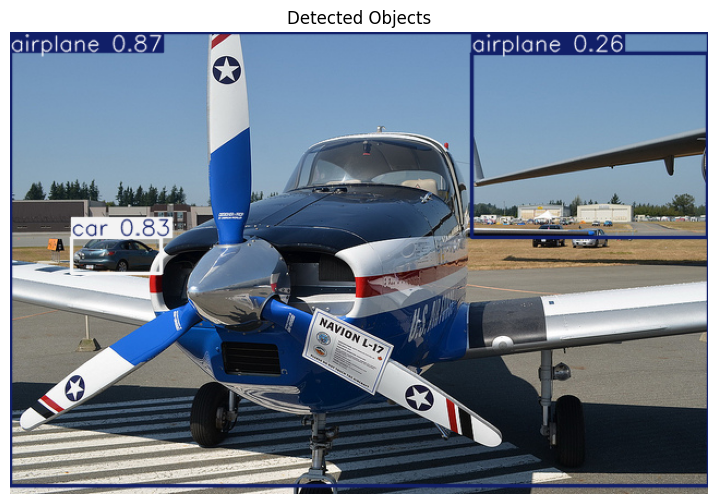

In [22]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load your trained model
model_path = r"/content/coco_trained3.pt"  # Change this to your actual model path
model = YOLO(model_path)

# File to detect (image)
file_path = r"/content/extracted_files/coco2017_subset/train2017/000000000247.jpg"  # Change to your image path

# Run inference
results = model(file_path)

# Get the detected image
for result in results:
    img = result.plot()  # Get image with detections (BGR format)

    # Convert BGR to RGB for Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis("off")  # Hide axes
    plt.title("Detected Objects")
    plt.show()
